In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pip install decorator==5.0.9

import re
import imp
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install cltk==1.0.22

Note: you may need to restart the kernel to use updated packages.


In [4]:
# importing local modules

import sys
sys.path.append('../src/')

import text_cleanup.text_cleanup as thesisCleanUp
import preprocessing.text_preprocessing as thesisTextPreprocessing
import data.reader as thesisDataReader
import utils.utils as thesisUtils
import features.tf_idf.n_gram as thesisTfIdfNgramFeatures
import similarities.cosine as thesisCosineSimilarities
import vocabulary.vocabulary as thesisVocabulary
import features.lexical as thesisLexicalFeatures
import similarities.cosine as thesisCosineSimilarity

imp.reload(thesisLexicalFeatures)
imp.reload(thesisCosineSimilarity)
imp.reload(thesisCleanUp)
imp.reload(thesisTextPreprocessing)
imp.reload(thesisDataReader)
imp.reload(thesisUtils)
imp.reload(thesisTfIdfNgramFeatures)
imp.reload(thesisVocabulary)
imp.reload(thesisCosineSimilarities)

<module 'similarities.cosine' from '../src/similarities/cosine.py'>

# Data high level overview

Here we are looking at some properties of available data: like amount of paragraphs, words, characters, etc...


In [83]:
def data_high_level_overview():
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_corpus(), "zwickau"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_corpus(), "london"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_corpus(), "breslau")
    ])

    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers')
    
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_by_3_sentences(), "zwickau_3_sen"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_by_3_sentences(), "london_3_sen"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_by_3_sentences(), "breslau_3_sen")
    ])

    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers separated by 3 sentences')
    
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_by_2_sentences(), "zwickau_2_sen"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_by_2_sentences(), "london_2_sen"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_by_2_sentences(), "breslau_2_sen")
    ])

    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers separated by 2 sentences')

,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau,170609.0,26860.0,6063.0,321.0,4045.0
london,190575.0,30042.0,6509.0,317.0,4268.0
breslau,62525.0,9906.0,2953.0,71.0,2075.0


,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau_3_sen,170609.0,26860.0,6063.0,397.0,4045.0
london_3_sen,190575.0,30042.0,6509.0,428.0,4268.0
breslau_3_sen,62525.0,9906.0,2953.0,121.0,2075.0


,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau_2_sen,170609.0,26860.0,6063.0,417.0,4045.0
london_2_sen,190575.0,30042.0,6509.0,448.0,4268.0
breslau_2_sen,62525.0,9906.0,2953.0,130.0,2075.0


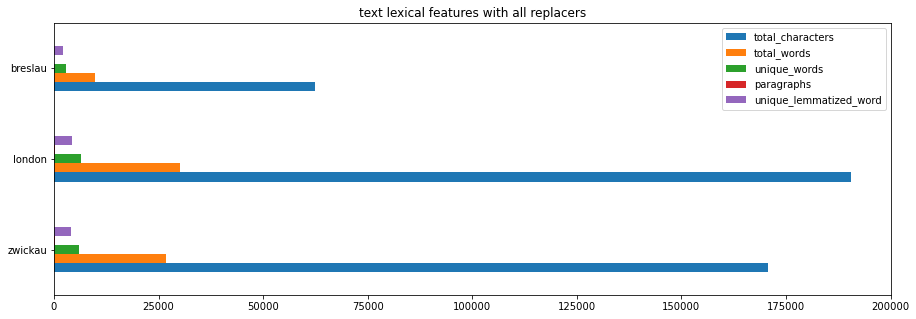

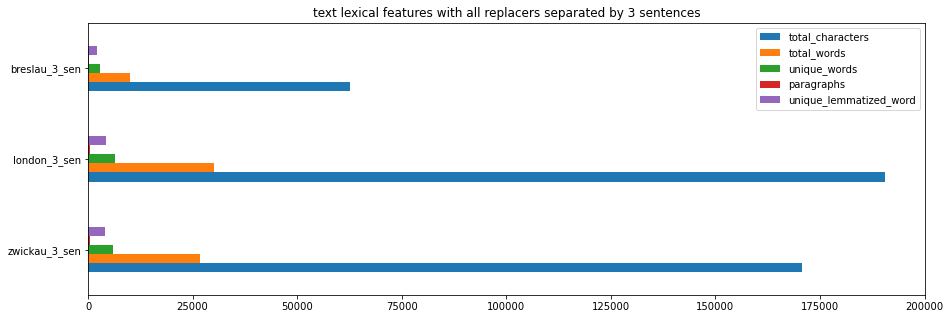

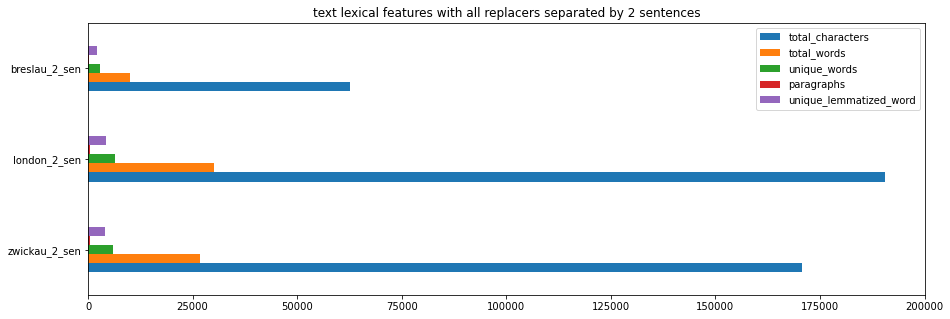

In [84]:
data_high_level_overview()

# Unique vocabulary
After our meeting 20.4, Yoni asked if we can have vocabulary of the words that appears in one version with counter bigger than 3 (for example) and does not appear in another 2 version

**UPDT**: cause unique vocabulary is very small for every version I choose threshold 1

In [49]:
def unique_vocabulary():
    df = thesisVocabulary.unique_vocabulary()
    df.to_csv('../computed_data/text_to_text/3_version_unique_vocabulary.csv')
    return df

In [48]:
unique_vocabulary()

,version,word,count
0,london,accepit,9
1,london,belonas,8
2,london,suanir,8
3,london,misit,7
4,london,aput,6
...,...,...,...
300,breslau,uiii,2
301,breslau,urbes,2
302,breslau,diuisionis,2
303,breslau,arsur,2


# Shared vocabulary

Create vocabulary that shared in vesion a and b, but not in c - for all permutations

In [101]:
def shared_vocabulary():
    london_corpus = thesisDataReader.get_london_corpus()
    zwickau_corpus = thesisDataReader.get_zwickau_corpus()
    breslau_corpus = thesisDataReader.get_breslau_corpus()
    
    zwickau_london_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        zwickau_corpus, 'zwickau',
        london_corpus, 'london',
        breslau_corpus
    )
    london_zwickau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        london_corpus, 'london',
        zwickau_corpus, 'zwickau',
        breslau_corpus
    )
    zwickau_breslau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        zwickau_corpus, 'zwickau',
        breslau_corpus, 'breslau',
        london_corpus
    )
    london_breslau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        london_corpus, 'london',
        breslau_corpus, 'breslau',
        zwickau_corpus
    )
    
    return [
        zwickau_london_shared_vocabulary,
        zwickau_breslau_shared_vocabulary,
        london_zwickau_shared_vocabulary,
        london_breslau_shared_vocabulary
    ]

def create_shared_vocabulary_df(shared_vocabulary):
    columns = [
        'shared_word', 
        'version a name', 
        'version a count',
        'version b name', 
        'version b count',
    ]
    all_data = []
    for shared_word in shared_vocabulary:
        data = [shared_word]
        
        for version_name in shared_vocabulary[shared_word]:
            data.append(version_name)
            data.append(shared_vocabulary[shared_word][version_name])
            
        all_data.append(data)
        
    return pd.DataFrame(all_data, columns=columns)

def create_shared_vocabulary_dfs():
    [
        zwickau_london_shared_vocabulary,
        zwickau_breslau_shared_vocabulary,
        london_zwickau_shared_vocabulary,
        london_breslau_shared_vocabulary
    ] = shared_vocabulary()
    
    zwickau_breslau_shared_vocabulary_df = create_shared_vocabulary_df(zwickau_breslau_shared_vocabulary)
    zwickau_breslau_shared_vocabulary_df.to_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/zwickau_breslau.csv')
    display(zwickau_breslau_shared_vocabulary_df)
    
    london_zwickau_shared_vocabulary_df = create_shared_vocabulary_df(london_zwickau_shared_vocabulary)
    london_zwickau_shared_vocabulary_df.to_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/london_zwickau.csv')
    display(london_zwickau_shared_vocabulary_df)
    
    london_breslau_shared_vocabulary_df = create_shared_vocabulary_df(london_breslau_shared_vocabulary)
    london_breslau_shared_vocabulary_df.to_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/london_breslau.csv')
    display(london_breslau_shared_vocabulary_df)

In [102]:
create_shared_vocabulary_dfs()

,shared_word,version a name,version a count,version b name,version b count
0,lempna,zwickau,8,breslau,1
1,israhel,zwickau,6,breslau,4
2,corrosaim,zwickau,6,breslau,5
3,engadi,zwickau,5,breslau,3
4,ceila,zwickau,4,breslau,4
...,...,...,...,...,...
162,placuerit,zwickau,1,breslau,1
163,fures,zwickau,1,breslau,1
164,n,zwickau,1,breslau,1
165,io,zwickau,1,breslau,1


,shared_word,version a name,version a count,version b name,version b count
0,iacere,london,19,zwickau,14
1,longum,london,15,zwickau,10
2,oppidum,london,15,zwickau,1
3,ueni,london,15,zwickau,10
4,campo,london,13,zwickau,7
...,...,...,...,...,...
2794,terrere,london,1,zwickau,1
2795,margat,london,1,zwickau,2
2796,ualaniam,london,1,zwickau,1
2797,doram,london,1,zwickau,1


,shared_word,version a name,version a count,version b name,version b count
0,pilistiim,london,11,breslau,2
1,deinde,london,9,breslau,10
2,quatuor,london,8,breslau,4
3,acconensi,london,6,breslau,1
4,magedo,london,6,breslau,1
...,...,...,...,...,...
152,ueneratione,london,1,breslau,2
153,inquit,london,1,breslau,1
154,nouam,london,1,breslau,1
155,ramatam,london,1,breslau,1


# statistics df: compares version similarity mean score in order to determinate if version more similar to self or to compared version

In [151]:
def check_inner_cross_mean(statistics_df, version_name):
    features = statistics_df.feature_name.unique()
    
    for feature in features:
        total = 0
        
        version_inner_df = statistics_df.loc[
            (statistics_df['cross/inner'] == 'inner') &
            (statistics_df['version'] == version_name) & 
            (statistics_df['feature_name'] == feature)
        ]
        version_cross_df = statistics_df.loc[
            (statistics_df['cross/inner'] == 'cross') &
            (statistics_df['version'] == version_name) & 
            (statistics_df['feature_name'] == feature)
        ]
        
        for i, d in version_cross_df.iterrows():
            cross_mean_val = d['mean']
            p_index = d['p_#']
            inner_mean_val = version_inner_df.loc[
                (version_inner_df['p_#'] == p_index) &
                (version_inner_df['feature_name'] == feature),
                'mean'
            ].values[0]
            
            cross_inner_mean_diff = cross_mean_val - inner_mean_val
            if cross_inner_mean_diff > 0:
                statistics_df.loc[
                    (statistics_df['version'] == version_name) &
                    (statistics_df['cross/inner'] == 'inner') &
                    (statistics_df['p_#'] == p_index) & 
                    (statistics_df['feature_name'] == feature),
                    'more_simmilar_to_compared'
                ] = True
            else:
                statistics_df.loc[
                    (statistics_df['version'] == version_name) &
                    (statistics_df['cross/inner'] == 'inner') &
                    (statistics_df['p_#'] == p_index) & 
                    (statistics_df['feature_name'] == feature),
                    'more_simmilar_to_compared'
                ] = False
                total += 1
            statistics_df.loc[
                (statistics_df['version'] == version_name) &
                (statistics_df['cross/inner'] == 'inner') &
                (statistics_df['p_#'] == p_index) & 
                (statistics_df['feature_name'] == feature),
                'cross_inner_mean_diff'
                ] = cross_inner_mean_diff
            
        print(f'version: {version_name}, for feature: {feature}, number of inner lowe that cross is: {total}')
        
def similar_to_self_or_to_compared(zwickau_corpus, london_corpus, breslau_corpus):    
    statistics_df_zwickau_to_london = thesisCosineSimilarity.create_statistics_df(
        zwickau_corpus, 
        london_corpus, 
        'zwickau_to_london'
    )
    statistics_df_zwickau_to_breslau = thesisCosineSimilarity.create_statistics_df(
        zwickau_corpus, 
        breslau_corpus, 
        'zwickau_to_breslau'
    )
    
    statistics_df_london_to_zwickau = thesisCosineSimilarity.create_statistics_df(
        london_corpus, 
        zwickau_corpus, 
        'london_to_zwickau'
    )
    statistics_df_london_to_breslau = thesisCosineSimilarity.create_statistics_df(
        london_corpus, 
        breslau_corpus, 
        'london_to_breslau'
    )
    statistics_df_breslau_to_zwickau = thesisCosineSimilarity.create_statistics_df(
        breslau_corpus, 
        zwickau_corpus, 
        'breslau_to_zwickau'
    )
    statistics_df_breslau_to_london = thesisCosineSimilarity.create_statistics_df(
        breslau_corpus, 
        london_corpus, 
        'breslau_to_london'
    )
    
    statistics_df_combined = pd.concat([
        statistics_df_zwickau_to_london, 
        statistics_df_zwickau_to_breslau,
        statistics_df_london_to_zwickau,
        statistics_df_london_to_breslau,
        statistics_df_breslau_to_zwickau,
        statistics_df_breslau_to_london,
    ])
    
    check_inner_cross_mean(statistics_df_combined, 'zwickau_to_london')
    check_inner_cross_mean(statistics_df_combined, 'zwickau_to_breslau')
    
    check_inner_cross_mean(statistics_df_combined, 'london_to_zwickau')
    check_inner_cross_mean(statistics_df_combined, 'london_to_breslau')
    
    check_inner_cross_mean(statistics_df_combined, 'breslau_to_zwickau')
    check_inner_cross_mean(statistics_df_combined, 'breslau_to_london')
    
    return statistics_df_combined

In [152]:
statistics_df = similar_to_self_or_to_compared(
    thesisDataReader.get_zwickau_corpus(),
    thesisDataReader.get_london_corpus(),
    thesisDataReader.get_breslau_corpus()
)
statistics_df

version: zwickau_to_london, for feature: 5_gram, number of inner lowe that cross is: 15
version: zwickau_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 0
version: london_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 279
version: london_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 1
version: breslau_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 71
version: breslau_to_london, for feature: 5_gram, number of inner lowe that cross is: 71


,feature_name,p_#,cross/inner,mean,std,min,25%,50%,75%,max,...,most_similar_p_#,most_similar_score,most_similar_p_length,most_similar_dropped,most_similar_dropped_p_#,most_similar_dropperd_score,most_similar_dropped_p_length,version,more_simmilar_to_compared,cross_inner_mean_diff
0,5_gram,0,inner,0.009503,0.018005,0.000000,0.000000,0.002609,0.011606,0.159225,...,320,0.159225,53,None,NaN,NaN,NaN,zwickau_to_london,True,0.001758
1,5_gram,1,inner,0.032343,0.018099,0.000000,0.018490,0.030228,0.042233,0.103204,...,6,0.103204,1578,None,NaN,NaN,NaN,zwickau_to_london,True,0.002302
2,5_gram,2,inner,0.023968,0.014803,0.000000,0.013667,0.021623,0.032216,0.099063,...,211,0.099063,411,None,NaN,NaN,NaN,zwickau_to_london,True,0.001047
3,5_gram,3,inner,0.030280,0.017046,0.000000,0.017822,0.029289,0.039827,0.102587,...,168,0.102587,1499,None,NaN,NaN,NaN,zwickau_to_london,True,0.002040
4,5_gram,4,inner,0.027132,0.017271,0.000000,0.015075,0.024053,0.035905,0.114511,...,278,0.114511,1007,None,NaN,NaN,NaN,zwickau_to_london,True,0.001175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,5_gram,66,cross,0.039565,0.037914,0.000000,0.020566,0.030437,0.044622,0.479348,...,200,0.479348,328,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
138,5_gram,67,cross,0.042295,0.034790,0.000000,0.024841,0.035565,0.047674,0.357403,...,201,0.357403,522,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
139,5_gram,68,cross,0.028837,0.031707,0.000000,0.013405,0.022573,0.034343,0.442933,...,202,0.442933,417,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
140,5_gram,69,cross,0.053503,0.043016,0.000000,0.030742,0.043439,0.060888,0.477705,...,203,0.477705,517,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN


In [153]:
statistics_df.to_csv('../computed_data/statistics/3_versions_by_new_line.csv')

In [154]:
statistics_df_by_3_sentences = similar_to_self_or_to_compared(
    thesisDataReader.get_zwickau_by_3_sentences(),
    thesisDataReader.get_london_by_3_sentences(),
    thesisDataReader.get_breslau_by_3_sentences()
)
statistics_df_by_3_sentences

version: zwickau_to_london, for feature: 5_gram, number of inner lowe that cross is: 60
version: zwickau_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 12
version: london_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 276
version: london_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 19
version: breslau_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 119
version: breslau_to_london, for feature: 5_gram, number of inner lowe that cross is: 118


,feature_name,p_#,cross/inner,mean,std,min,25%,50%,75%,max,...,most_similar_p_#,most_similar_score,most_similar_p_length,most_similar_dropped,most_similar_dropped_p_#,most_similar_dropperd_score,most_similar_dropped_p_length,version,more_simmilar_to_compared,cross_inner_mean_diff
0,5_gram,0,inner,0.008729,0.017075,0.000000,0.000000,0.001821,0.010824,0.161337,...,396,0.161337,53,None,NaN,NaN,NaN,zwickau_to_london,True,0.001323
1,5_gram,1,inner,0.031004,0.015918,0.000000,0.018854,0.029477,0.040074,0.103852,...,6,0.103852,1578,None,NaN,NaN,NaN,zwickau_to_london,True,0.001133
2,5_gram,2,inner,0.022773,0.013597,0.000000,0.013501,0.020234,0.029781,0.099285,...,239,0.099285,411,None,NaN,NaN,NaN,zwickau_to_london,True,0.000402
3,5_gram,3,inner,0.028436,0.016113,0.000000,0.016786,0.025948,0.036850,0.104127,...,5,0.104127,1235,None,NaN,NaN,NaN,zwickau_to_london,True,0.001259
4,5_gram,4,inner,0.025930,0.015582,0.000000,0.015589,0.023386,0.032646,0.115363,...,327,0.115363,1583,None,NaN,NaN,NaN,zwickau_to_london,True,0.000435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,5_gram,116,cross,0.031523,0.032730,0.000000,0.016034,0.024613,0.037334,0.399778,...,250,0.399778,522,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
238,5_gram,117,cross,0.024467,0.019757,0.000000,0.012080,0.019646,0.030576,0.139911,...,205,0.139911,352,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
239,5_gram,118,cross,0.026302,0.028238,0.000000,0.013048,0.020790,0.032206,0.442968,...,251,0.442968,417,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
240,5_gram,119,cross,0.049209,0.038628,0.000000,0.029027,0.040283,0.055145,0.476707,...,252,0.476707,517,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN


In [155]:
statistics_df_by_3_sentences.to_csv('../computed_data/statistics/3_versions_by_3_sentences.csv')

# p aligment by 5_gram split to 3 sentences

During last meeting 20.4 we saw that paragraphs that aligned together, has very different lenght (very short VS very long) we are thinking that it is happend because up till now we created corpus based on \n split, so we said that we will try to split each paragraph to 3 sentences, if paragraph is 4 or 5 sentences we will keep them together

In [14]:
london_corpus = thesisDataReader.get_london_by_3_sentences()
zwickau_corpus = thesisDataReader.get_zwickau_by_3_sentences()
breslau_corpus = thesisDataReader.get_breslau_by_3_sentences()

In [15]:
# zwickau_london_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(zwickau_corpus, london_corpus)
# zwickau_breslau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(zwickau_corpus, breslau_corpus)

# london_zwickau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(london_corpus, zwickau_corpus)
# london_breslau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(london_corpus, breslau_corpus)

# breslau_zwickau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(breslau_corpus, zwickau_corpus)
# breslau_london_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(breslau_corpus, london_corpus)

In [16]:
# np.save('../computed_data/similarities/cross_version/sentences_by_3/zwickau_london_similarities.npy', zwickau_london_similarities)
# np.save('../computed_data/similarities/cross_version/sentences_by_3/zwickau_breslau_similarities.npy', zwickau_breslau_similarities)

# np.save('../computed_data/similarities/cross_version/sentences_by_3/london_zwickau_similarities.npy', london_zwickau_similarities)
# np.save('../computed_data/similarities/cross_version/sentences_by_3/london_breslau_similarities.npy', london_breslau_similarities)

# np.save('../computed_data/similarities/cross_version/sentences_by_3/breslau_zwickau_similarities.npy', breslau_zwickau_similarities)
# np.save('../computed_data/similarities/cross_version/sentences_by_3/breslau_london_similarities.npy', breslau_london_similarities)

In [17]:
# zwickau_london_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(zwickau_london_similarities)
# zwickau_breslau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(zwickau_breslau_similarities)

# london_zwickau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(london_zwickau_similarities)
# london_breslau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(london_breslau_similarities)

# breslau_zwickau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(breslau_zwickau_similarities)
# breslau_london_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(breslau_london_similarities)

In [18]:
zwickau_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, breslau_corpus)
zwickau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, london_corpus)

In [19]:
london_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, breslau_corpus)
london_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, zwickau_corpus)

In [20]:
breslau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, london_corpus)
breslau_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, zwickau_corpus)

In [21]:
def create_5_gram_text_aligments(original_version, version_1, best_matches_1, version_2, best_matches_2):
    p_aligment = []
    
    for i, best_match_1 in enumerate(best_matches_1):
        best_match_2 = best_matches_2[i]
        
        best_match_1_p, best_match_1_score = best_match_1['5_gram']
        best_match_2_p, best_match_2_score = best_match_2['5_gram']
        
        data = [
            original_version[i],
            
            version_1[best_match_1_p],
            best_match_1_p,
            best_match_1_score,
        
            version_2[best_match_2_p],
            best_match_2_p,
            best_match_2_score
        ]
        
        p_aligment.append(data)
    return p_aligment

In [22]:
def create_zwickau_p_aligment(
    zwickau_corpus,
    london_corpus,
    zwickau_london_best_smlrt,
    breslau_corpus,
    zwickau_breslau_best_smlrt,
):
    columns = [
        'zwickau text',
        'london text',
        'london p#',
        'score',
        'breslau text',
        'breslau p#',
        'score'
    ]
    p_aligment = create_5_gram_text_aligments(
        zwickau_corpus,
        london_corpus,
        zwickau_london_best_smlrt,
        breslau_corpus,
        zwickau_breslau_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)
    

In [23]:
def create_london_p_aligment(
    london_corpus, 
    zwickau_corpus, 
    london_zwickau_best_smlrt, 
    breslau_corpus, 
    london_breslau_best_smlrt
):
    columns = [
        'london text',
        'zwicau text',
        'zwicau p#',
        'score',
        'breslau text',
        'breslau p#',
        'score'
    ]
    p_aligment = create_5_gram_text_aligments(
        london_corpus,
        zwickau_corpus,
        london_zwickau_best_smlrt,
        breslau_corpus,
        london_breslau_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)

In [24]:
def create_breslau_p_aligment(
    breslau_corpus,
    zwickau_corpus, 
    breslau_zwickau_best_smlrt,
    london_corpus,
    breslau_london_best_smlrt,
):
    columns = [
        'breslau text',
        'zwicau text',
        'zwicau p#',
        'score',
        'london text',
        'london p#',
        'score'
    ]
    p_aligment = create_5_gram_text_aligments(
        breslau_corpus,
        zwickau_corpus,
        breslau_zwickau_best_smlrt,
        london_corpus,
        breslau_london_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)

In [25]:
zwickau_p_aligment_df = create_zwickau_p_aligment(    
    zwickau_corpus,
    london_corpus,
    zwickau_london_best_smlrt,
    breslau_corpus,
    zwickau_breslau_best_smlrt
)
london_p_aligment_df = create_london_p_aligment(
    london_corpus, 
    zwickau_corpus, 
    london_zwickau_best_smlrt, 
    breslau_corpus, 
    london_breslau_best_smlrt
)
breslau_p_aligment_df = create_breslau_p_aligment(
    breslau_corpus,
    zwickau_corpus, 
    breslau_zwickau_best_smlrt,
    london_corpus,
    breslau_london_best_smlrt,
)

In [26]:
zwickau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/zwickau_london_breslau.csv')
london_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/london_zwickau_breslau.csv')
breslau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/breslau_london_zwickau.csv')

<AxesSubplot:title={'center':'zwickau p aligment similarity score (by new line)'}>

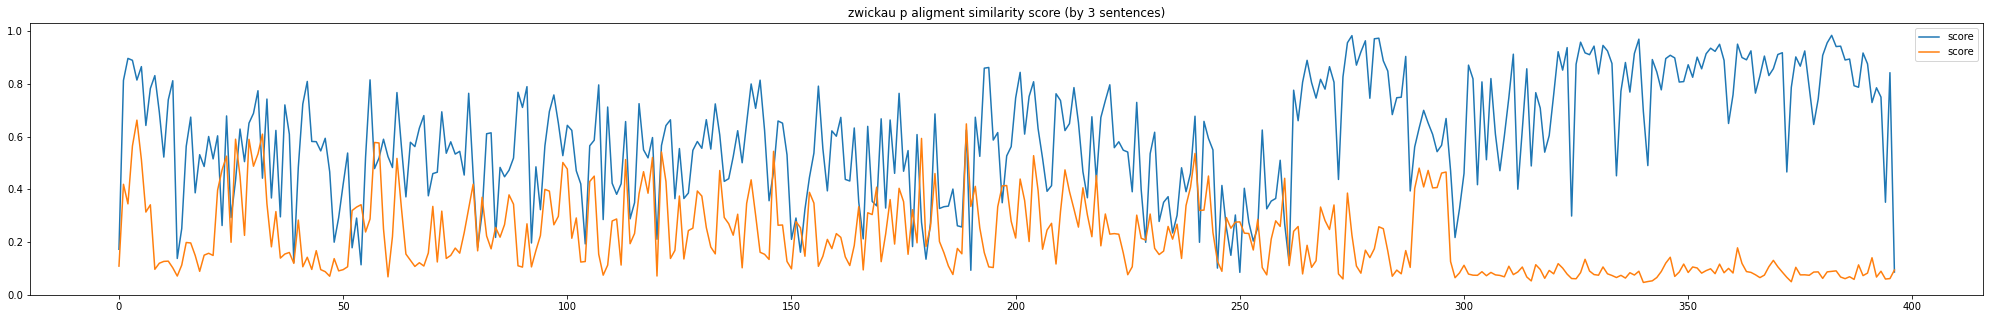

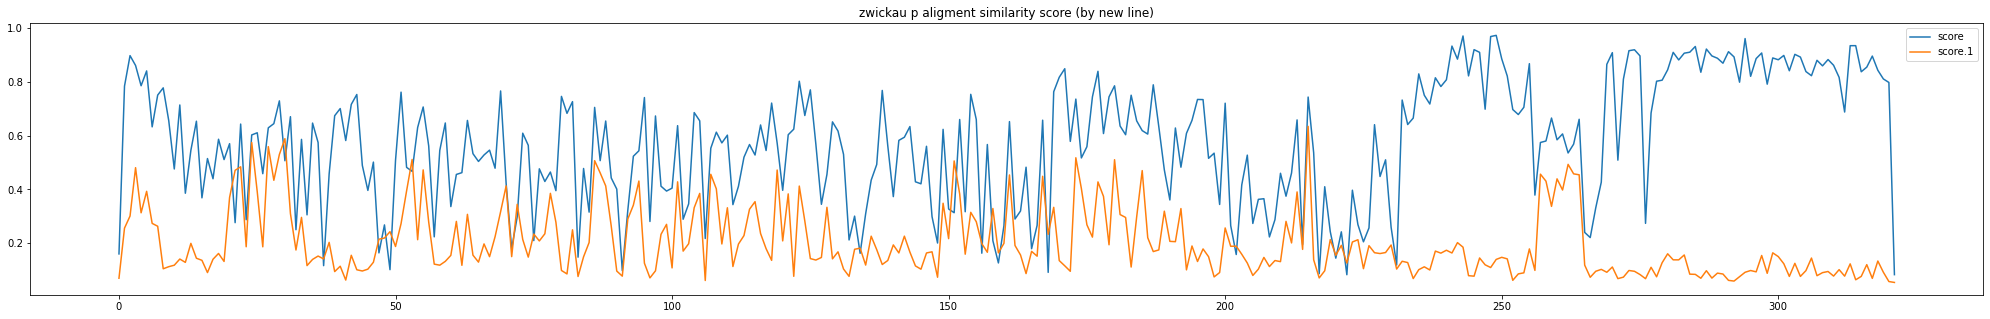

In [132]:
zwickau_p_aligment_df[['score']].plot(figsize=(35, 5), title='zwickau p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/zwickau_london_breslau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='zwickau p aligment similarity score (by new line)')

In [133]:
display(zwickau_p_aligment_df[['score']].describe())
display(pd.read_csv('../computed_data/p_aligment/zwickau_london_breslau.csv')[['score', 'score.1']].describe())

,score,score
count,397.000000,397.000000
mean,0.600293,0.214525
std,0.223072,0.140986
min,0.084326,0.046044
25%,0.440112,0.097681
50%,0.609555,0.167054
75%,0.785932,0.305127
max,0.984323,0.662385


,score,score.1
count,322.000000,322.000000
mean,0.576689,0.201493
std,0.226696,0.125397
min,0.082701,0.054012
25%,0.411374,0.105889
50%,0.601789,0.160958
75%,0.752913,0.263367
max,0.972249,0.633956


<AxesSubplot:title={'center':'london p aligment similarity score (by new line)'}>

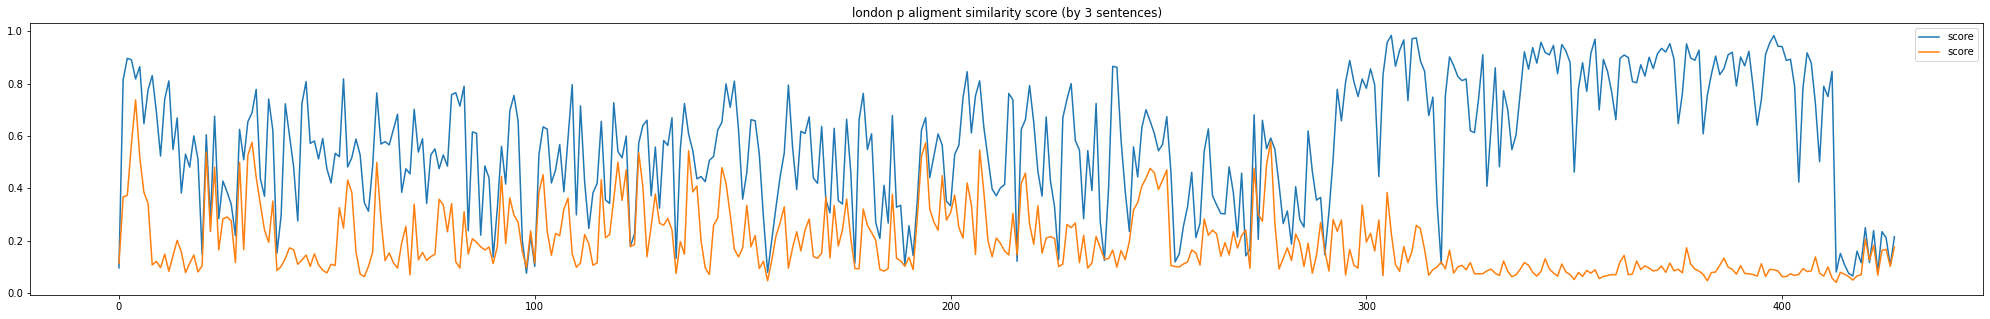

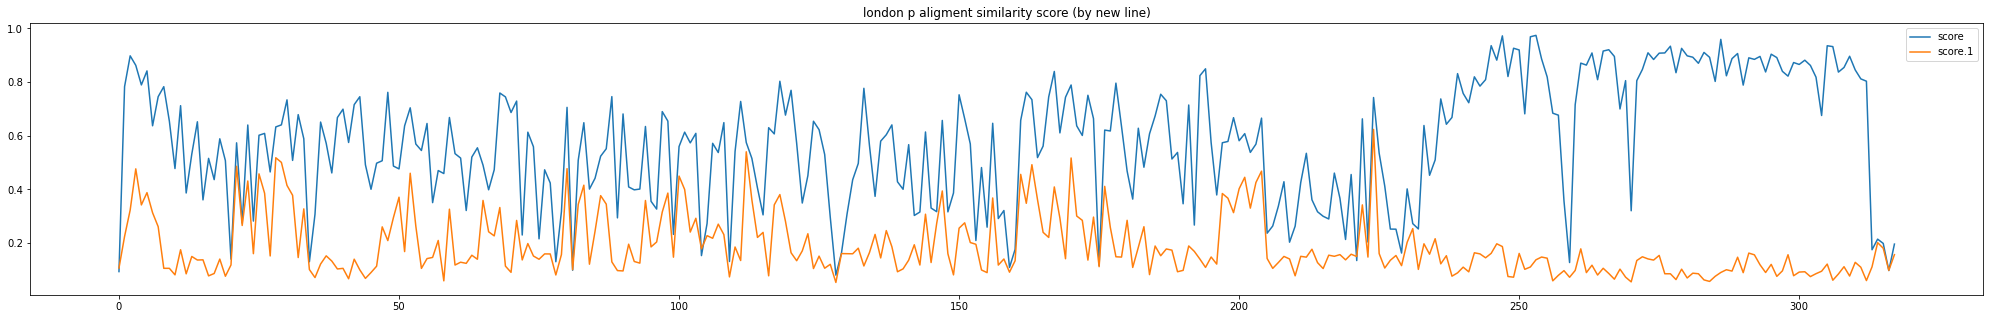

In [134]:
london_p_aligment_df[['score']].plot(figsize=(35, 5), title='london p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/london_zwickau_breslau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='london p aligment similarity score (by new line)')

In [135]:
display(london_p_aligment_df[['score']].describe())
display(pd.read_csv('../computed_data/p_aligment/london_zwickau_breslau.csv')[['score', 'score.1']].describe())

,score,score
count,428.000000,428.000000
mean,0.572875,0.192493
std,0.239734,0.127021
min,0.064448,0.039787
25%,0.390660,0.094664
50%,0.589874,0.149492
75%,0.773520,0.258233
max,0.984409,0.737808


,score,score.1
count,318.000000,318.000000
mean,0.580992,0.186445
std,0.226031,0.113091
min,0.080923,0.053676
25%,0.406627,0.105578
50%,0.606969,0.148378
75%,0.758824,0.234428
max,0.973818,0.623667


<AxesSubplot:title={'center':'breslau p aligment similarity score (by new line)'}>

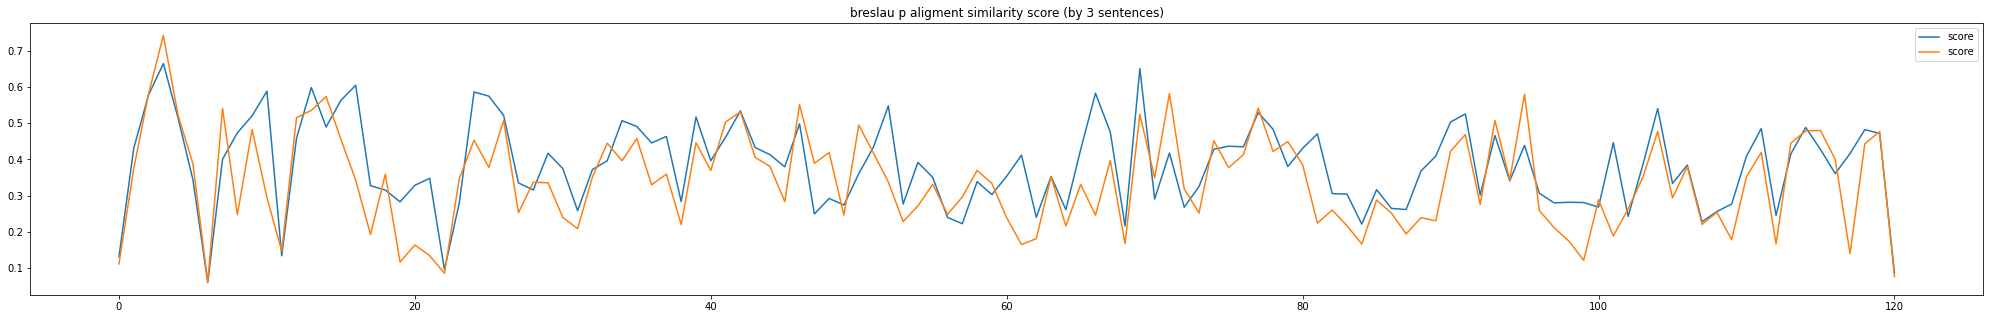

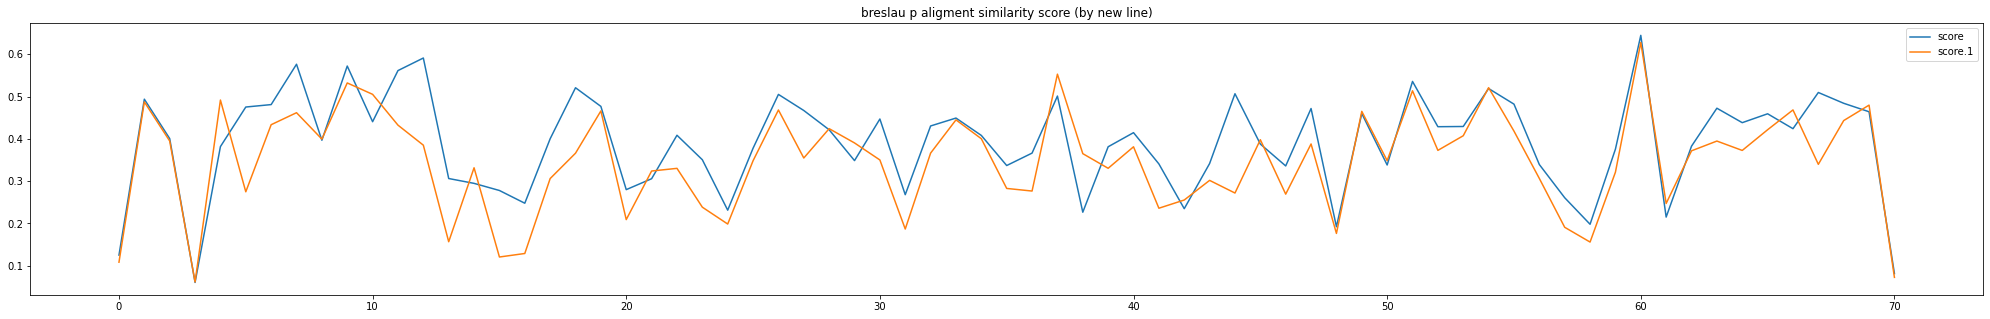

In [136]:
breslau_p_aligment_df[['score']].plot(figsize=(35, 5), title='breslau p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/breslau_london_zwickau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='breslau p aligment similarity score (by new line)')

In [137]:
display(breslau_p_aligment_df[['score']].describe())
display(pd.read_csv('../computed_data/p_aligment/breslau_london_zwickau.csv')[['score', 'score.1']].describe())

,score,score
count,121.000000,121.000000
mean,0.384031,0.338882
std,0.120816,0.133102
min,0.060753,0.062778
25%,0.290673,0.239288
50%,0.385277,0.343334
75%,0.471292,0.444542
max,0.663900,0.741795


,score,score.1
count,71.000000,71.000000
mean,0.390881,0.346706
std,0.119141,0.121027
min,0.060284,0.061426
25%,0.336308,0.273221
50%,0.407957,0.365997
75%,0.473754,0.428147
max,0.644676,0.627791


# p aligment by 5_gram split by new line

In [9]:
zwickau_corpus = thesisDataReader.get_zwickau_corpus()
london_corpus = thesisDataReader.get_london_corpus()
breslau_corpus = thesisDataReader.get_breslau_corpus()

In [10]:
zwickau_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, breslau_corpus)
zwickau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, london_corpus)

In [11]:
london_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, breslau_corpus)
london_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, zwickau_corpus)

In [12]:
breslau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, london_corpus)
breslau_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, zwickau_corpus)

In [13]:
zwickau_p_aligment_df = create_zwickau_p_aligment(    
    zwickau_corpus,
    london_corpus,
    zwickau_london_best_smlrt,
    breslau_corpus,
    zwickau_breslau_best_smlrt
)
london_p_aligment_df = create_london_p_aligment(
    london_corpus, 
    zwickau_corpus, 
    london_zwickau_best_smlrt, 
    breslau_corpus, 
    london_breslau_best_smlrt
)
breslau_p_aligment_df = create_breslau_p_aligment(
    breslau_corpus,
    zwickau_corpus, 
    breslau_zwickau_best_smlrt,
    london_corpus,
    breslau_london_best_smlrt,
)

In [14]:
zwickau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_new_line/zwickau_london_breslau.csv')
london_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_new_line/london_zwickau_breslau.csv')
breslau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_new_line/breslau_london_zwickau.csv')

# words counts

In [51]:
def create_n_gram_frequency(n_gram, corpus):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram), analyzer='char').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq

def creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words,
    
    corpus_2, 
    corpus_2_name, 
    corpus_2_total_words,
    
    corpus_3,
    corpus_3_name,
    corpus_3_total_words,
    
    n_gram
):    
    dictionary = {}
    
    counter_sorted_corpus_1 = create_n_gram_frequency(n_gram, corpus_1)
    counter_sorted_corpus_2 = create_n_gram_frequency(n_gram, corpus_2)
    counter_sorted_corpus_3 = create_n_gram_frequency(n_gram, corpus_3)
    
    def add_to_dictionary(counters, corpus_name):
        for i in counters:
            word = i[0].replace(' ', '_')
            count = i[1]
            if word not in dictionary:
                dictionary[word] = {}
            dictionary[word][corpus_name] = count

    add_to_dictionary(counter_sorted_corpus_1, corpus_1_name)
    add_to_dictionary(counter_sorted_corpus_2, corpus_2_name)
    add_to_dictionary(counter_sorted_corpus_3, corpus_3_name)
    
    return create_data(
        dictionary, 
        corpus_1_name, 
        corpus_2_name,  
        corpus_3_name,
        f'count_vectorizer_{n_gram}_gram',
        corpus_1_total_words,
        corpus_2_total_words,
        corpus_3_total_words
    )

# # here is neat graph for count: https://www.absentdata.com/python-graphs/python-word-frequency/
def create_words_frequency(corpus):    
    word_counter =  Counter(' '.join(corpus).split())
    return sorted(word_counter.items(), key=lambda item: item[1], reverse=True)

def create_data(
    dictionary, 
    corpus_1_name, 
    corpus_2_name, 
    corpus_3_name,
    feature_name,
    corpus_1_total_words,
    corpus_2_total_words,
    corpus_3_total_words,
):
    data = []
    for i in dictionary:
        corpus_1_counter = 0 if corpus_1_name not in dictionary[i] else dictionary[i][corpus_1_name]
        corpus_2_counter = 0 if corpus_2_name not in dictionary[i] else dictionary[i][corpus_2_name]
        corpus_3_counter = 0 if corpus_3_name not in dictionary[i] else dictionary[i][corpus_3_name]
        
        all_counters = [corpus_1_counter, corpus_2_counter, corpus_3_counter]
        all_names = [corpus_1_name, corpus_2_name, corpus_3_name]
        max_version_name = all_names[np.argmax(all_counters)]
        
        corpus_1_counter_norm = corpus_1_counter / corpus_1_total_words
        corpus_2_counter_norm = corpus_2_counter / corpus_2_total_words
        corpus_3_counter_norm = corpus_3_counter / corpus_3_total_words
        
        data.append([
            feature_name,
            i,
            
            corpus_1_counter,
            corpus_1_counter_norm,
            
            corpus_2_counter,
            corpus_2_counter_norm,
            
            corpus_3_counter,
            corpus_3_counter_norm,
            
            get_ration_between_norms(corpus_1_counter_norm, corpus_2_counter_norm),
            get_ration_between_norms(corpus_1_counter_norm, corpus_3_counter_norm),
            get_ration_between_norms(corpus_2_counter_norm, corpus_3_counter_norm),
            
            max_version_name,
        ])
    return data

def get_ration_between_norms(norm_1, norm_2):
    if norm_1 == norm_2:
        return 1
    elif  norm_2 == 0:
        return 0
    
    return norm_1 / norm_2
        

def creat_word_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words,
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3,
    corpus_3_name,
    corspus_3_total_words
):    
    dictionary = {}
    
    counter_sorted_corpus_1 = create_words_frequency(corpus_1)
    counter_sorted_corpus_2 = create_words_frequency(corpus_2)
    counter_sorted_corpus_3 = create_words_frequency(corpus_3)
    
    def add_to_dictionary(counters, corpus_name):
        for i in counters:
            word = i[0]
            count = i[1]
            if word not in dictionary:
                dictionary[word] = {}
            dictionary[word][corpus_name] = count

    add_to_dictionary(counter_sorted_corpus_1, corpus_1_name)
    add_to_dictionary(counter_sorted_corpus_2, corpus_2_name)
    add_to_dictionary(counter_sorted_corpus_3, corpus_3_name)

    data = []
    return create_data(
        dictionary, 
        corpus_1_name, 
        corpus_2_name,
        corpus_3_name,
        'word_counter',
        corpus_1_total_words,
        corpus_2_total_words,
        corspus_3_total_words
    )

def creat_5_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
     
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words
):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 
    5
)

def creat_6_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words
):
    return creat_n_gram_frequency_data(    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,    
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 6)

def creat_7_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
       
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 7)

def creat_8_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
       
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 8)

def creat_9_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
      
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
     
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 9)

def creat_10_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
       
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 10)

def words_counts(zwickau_total_words, london_total_words, breslau_total_words):
    zwickau_corpus = thesisDataReader.get_zwickau_corpus()
    london_corpus = thesisDataReader.get_london_corpus()
    breslau_corpus = thesisDataReader.get_breslau_corpus()
    
    word_freq = creat_word_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        london_corpus,
        'london',
        london_total_words,
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    
    gram_5_frequency = creat_5_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words,
        
    )
    gram_6_frequency = creat_6_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_7_frequency = creat_7_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_8_frequency = creat_8_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_9_frequency = creat_9_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_10_frequency = creat_10_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    
    df_columns = [
    'feature_name', 
    'word',
        
    'zwickau', 
    'zwickau norm.',
        
    'london',
    'london norm.',
        
    'breslau',
    'breslau norm.',
        
    'zwickau / london',
    'zwickau / breslau',
    'london / breslau',
        
    'version with higher score',
    ]

    words_df = pd.DataFrame(
        word_freq + gram_5_frequency + gram_6_frequency + gram_7_frequency + gram_8_frequency + gram_9_frequency + gram_10_frequency,
        columns=df_columns
    )
    return words_df

In [52]:
zwickau_total_words = 26860
london_total_words = 30042
breslau_total_words = 9906

words_df = words_counts(zwickau_total_words, london_total_words, breslau_total_words)

In [53]:
words_df

,feature_name,word,zwickau,zwickau norm.,london,london norm.,breslau,breslau norm.,zwickau / london,zwickau / breslau,london / breslau,version with higher score
0,word_counter,et,1524,0.056739,1687,0.056155,494,0.049869,1.010399,1.137759,1.126050,london
1,word_counter,in,1043,0.038831,1149,0.038246,380,0.038361,1.015283,1.012262,0.997025,london
2,word_counter,est,601,0.022375,674,0.022435,207,0.020896,0.997327,1.070771,1.073641,london
3,word_counter,de,459,0.017089,531,0.017675,185,0.018676,0.966810,0.915026,0.946438,london
4,word_counter,ad,427,0.015897,441,0.014679,253,0.025540,1.082959,0.622443,0.574761,london
...,...,...,...,...,...,...,...,...,...,...,...,...
848256,count_vectorizer_10_gram,corrige_le,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau
848257,count_vectorizer_10_gram,orrige_lec,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau
848258,count_vectorizer_10_gram,rrige_lect,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau
848259,count_vectorizer_10_gram,rige_lecto,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau


In [54]:
for feature_name in [
    'word_counter',
    'count_vectorizer_5_gram',
    'count_vectorizer_6_gram',
    'count_vectorizer_7_gram',
    'count_vectorizer_8_gram',
    'count_vectorizer_9_gram',
    'count_vectorizer_10_gram'
]:
    words_df[
        words_df['feature_name'] == feature_name
    ].to_csv(f'../computed_data/words_count/{feature_name}.csv')

# vocabulary mapping
in our last meeting at 3.4.22 I presented result that were made after total text cleanup according to Yoni table,
he asked if we can create map of words before change and after in order to provide easier understanding of the context

# p aligment on shared vocabulary
in our last meeting at 3.4.22 we found interesting pattern that for example word sinai not appears in one of the version (london or zwickau), it is interesting cause it can make show us that maybe one version does not include specific part at all or it has but using different vocabulary to describe the same event.
So we decided to take shared vocabulary and run p aligment for them in order to be able easily see those paragraphs.

In [5]:
word = "separata"
s = "et uidentur ile spelunce exterius esse una sed cum intraueris uidebis ab inuicem per parietem separata intratur autem primo ila et de ila in aliam in qua est sepulcrum domini in istam anteriorem intrauerunt mulieres quando dicebant quis reuoluet nobis lapidem ab ostio monumenti et ile lapis erat aduolutus hostio spelunce interioris et stat hodie magna pars eius in medio spelunce ante hoscium cui fuerat aduolutus alia uero medietas translata est in monte sion pro lapide altari superponendo quem uidi etiam ibi"
if re.search(r'\b' + word + r'\b', s):
    print("found")

found


In [62]:
def create_p_aligment_df_with_shared_words(shared_vocabulary_df, p_aligment_df, corpus):
    relevant_ps = []
    by_words = {}
    by_ps = {}
    
    for _, row in shared_vocabulary_df.iterrows():
        shared_word = row['shared_word']
        shared_word_in_main_version = row['version a count']
        by_word_key = f'{shared_word}({shared_word_in_main_version})'
        
        by_words[by_word_key] = []
        
        for i, p in enumerate(corpus):
            if re.search(r'\b' + shared_word + r'\b', p):
                relevant_ps.append(i)
                by_words[by_word_key].append(i)
                if by_ps.get(i) is None:
                    by_ps[i] = []
                by_ps[i].append(by_word_key)
    
    relevant_ps = np.unique(np.array(relevant_ps))
    relevant_df = p_aligment_df.iloc[relevant_ps].copy()
    
    shared_words_by_p = []
    for i in relevant_ps:
        shared_words_by_p.append(by_ps[i])
        
    relevant_df['shared_word'] = shared_words_by_p
    
    return relevant_df

In [65]:
def p_aligment_shared_vocabulary():
    london_corpus = thesisDataReader.get_london_by_3_sentences()
    zwickau_corpus = thesisDataReader.get_zwickau_by_3_sentences()
    breslau_corpus = thesisDataReader.get_breslau_by_3_sentences() 
    
    zwickau_breslau_shared_vocabulary_df = pd.read_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/zwickau_breslau.csv')
    london_zwickau_shared_vocabulary_df = pd.read_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/london_zwickau.csv')
    london_breslau_shared_vocabulary_df = pd.read_csv('../computed_data/text_to_text/vocabulary/shared_2_versions/london_breslau.csv')
    
    london_zwickau_breslau_p_aligment_sent_by_3 = pd.read_csv('../computed_data/p_aligment/sentences_by_3/london_zwickau_breslau.csv')
    breslau_london_zwickau_p_aligment_sent_by_3 = pd.read_csv('../computed_data/p_aligment/sentences_by_3/breslau_london_zwickau.csv')
    zwickau_london_breslau_p_aligment_sent_by_3 = pd.read_csv('../computed_data/p_aligment/sentences_by_3/zwickau_london_breslau.csv')

    # run over all shared words
    # find paragraphs that this word appear
    # take p aligment of this version for paragraphs that found

#     relevant_ps = []
#     by_words = {}
#     by_ps = {}
#     for _, row in london_breslau_shared_vocabulary_df.iterrows():
#         shared_word = row['shared_word']
#         shared_word_count_in_london = row['version a count']
#         by_word_key = f'{shared_word}({shared_word_count_in_london})'
        
#         by_words[by_word_key] = []
        
#         for i, p in enumerate(london_corpus):
#             if re.search(r'\b' + shared_word + r'\b', p):
#                 relevant_ps.append(i)
#                 by_words[by_word_key].append(i)
#                 if by_ps.get(i) is None:
#                     by_ps[i] = []
#                 by_ps[i].append(by_word_key)
    
#     relevant_df = london_zwickau_breslau_p_aligment_sent_by_3.iloc[np.unique(np.array(relevant_ps))].copy()
#     relevant_ps = np.unique(np.array(relevant_ps))
#     display(relevant_df)

#     shared_words_by_p = []
#     for i in relevant_ps:
#         shared_words_by_p.append(by_ps[i])
#     relevant_df['shared_word'] = shared_words_by_p
#     display(relevant_df)
#     relevant_df.to_csv('../computed_data/p_aligment/on_shared_vocabulary/sentences_by_3/london_zwickau_breslau.csv')
    
    london_zwickau_breslau_p_aligment_by_shared_words = create_p_aligment_df_with_shared_words(
        london_breslau_shared_vocabulary_df,
        london_zwickau_breslau_p_aligment_sent_by_3,
        london_corpus
    )
    london_zwickau_breslau_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/on_shared_vocabulary/sentences_by_3/london_zwickau_breslau_1.csv')
    display(london_zwickau_breslau_p_aligment_by_shared_words)

In [66]:
p_aligment_shared_vocabulary()

,Unnamed: 0,london text,zwicau text,zwicau p#,score,breslau text,breslau p#,score.1,shared_word
1,1,cum in ueteribus historiis legamus sicut dicit...,cum sicut dicit ieronimus quosdam inueniamus l...,1,0.814359,uenerabantur quondam iudei sancta sanctorum qu...,1,0.366357,[cerubin(2)]
3,3,redeat post hec in ierusalem ut uideat et audi...,redeat post in ierusalem uideat et audiat in t...,3,0.891031,quis cristianus non relictis omnibus que habet...,2,0.569442,[iudicatum(1)]
4,4,sunt preterea quedam que in locis ilis deuotio...,sunt preterea quedam que in locis ilis deuotio...,4,0.817592,sunt preterea que deuotionem excitant ampliore...,3,0.737808,"[quot(3), emitentes(1)]"
5,5,eia domine deus uideo secundum ueteres histori...,eia domine deus uideo secundum ueteres histori...,5,0.865110,historias abraham caldeam rabot campum sennaar...,4,0.518881,"[deserentem(1), transuolantem(1), consecrauit(1)]"
6,6,uerum ego burcardus ordinis predicatorum uiden...,uerum ego frater burcardus ordinis fratrum pre...,6,0.646722,quid plura tarditatem ingemisco cristianorum n...,5,0.384196,"[surianis(1), querebam(1), interrogans(1)]"
...,...,...,...,...,...,...,...,...,...
418,418,inde in die iohannis baptiste celebraui missam...,in festo annuntiationis marie me presente idem...,334,0.159213,quis cristianus non relictis omnibus que habet...,2,0.064853,[celebraui(2)]
419,419,deinde rex mii et sotio meo nongentas dracmas ...,multa alia uidi et perambulaui in terra ila qu...,348,0.115030,procedentibus de accon contra directam uiam aq...,10,0.068597,[deinde(9)]
422,422,tribus efraim a iordane usque gaderam iuxta io...,isti duo montes ita sunt dispositi ut gelboe s...,130,0.237946,ad pedem eiusdem montis penitia uero regio ext...,8,0.181982,"[magedo(6), betsam(2)]"
426,426,tribus dan loca conualis iuxta mare magnum ad ...,isti duo montes ita sunt dispositi ut gelboe s...,130,0.104708,isti duo montes ita sunt dispositi ut hermon s...,45,0.101291,"[ackaron(2), ramatam(1)]"


# Tests

In [36]:
imp.reload(thesisCleanUp)
%run ../src/text_cleanup/text_cleanup.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


In [37]:
imp.reload(thesisUtils)
%run ../src/utils/utils.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [87]:
imp.reload(thesisVocabulary)
%run ../src/vocabulary/vocabulary.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
